In [8]:
import tensorflow as tf

# Avoid OOM errors by setting GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
zip_file_path = '/content/drive/MyDrive/Imgdata.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [10]:
! pip install mtcnn

Key Changes:
Added expansion_factor Parameter: This allows you to control how much you want to expand the bounding box size. A factor of 0.3 increases the width and height by 30%.

Adjusted Bounding Box Calculation: Calculates the new bounding box dimensions and coordinates, making sure they stay within the image bounds using max and min functions.

Resize Expanded Face Image: After expanding the bounding box, the face image is cropped and resized to (224, 224).

You can adjust the expansion_factor as needed based on your requirements.



In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from mtcnn import MTCNN

In [ ]:
# Define dataset path
dataset_dir = '/content/Imgdata'

# Check the folders
print("Subfolders in dataset directory:", os.listdir(dataset_dir))

Subfolders in dataset directory: ['with_mask', 'without_mask']


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step


<ipython-input-7-0251e775661f>:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts, palette='viridis')


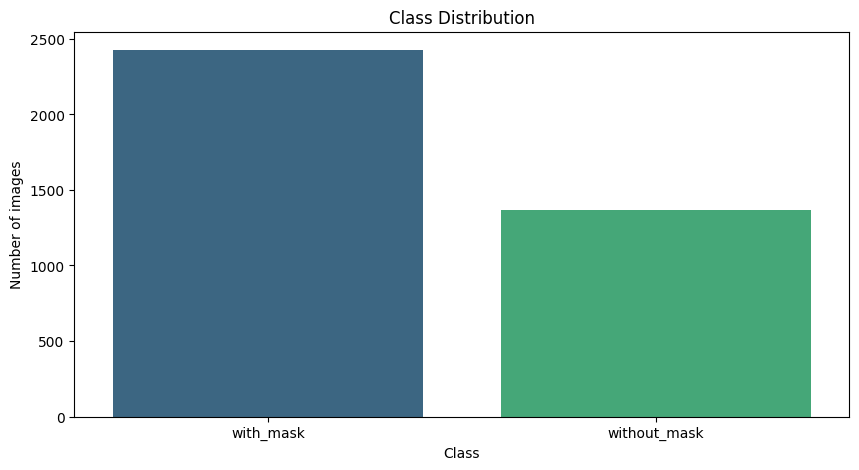

no. of images:  3793
no. of labels:  3793


In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split
# from mtcnn import MTCNN
# !pip install seaborn # install the seaborn plotting library
import seaborn as sns

# Paths
data_dir = '/content/Imgdata'
with_mask_dir = os.path.join(data_dir, 'with_mask')
without_mask_dir = os.path.join(data_dir, 'without_mask')

# Load and preprocess the images
def load_and_preprocess_images(data_dir, expansion_factor=0.3):
    detector = MTCNN(
        min_face_size=15,  # Adjust as needed
        scale_factor=0.45,  # Adjust as needed
        steps_threshold=[0.4, 0.4, 0.3]  # Lower values for more sensitivity
    )
    images = []
    labels = []
    for label, category in enumerate(['with_mask', 'without_mask']):
        category_dir = os.path.join(data_dir, category)
        for file_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                faces = detector.detect_faces(img)
                h, w, _ = img.shape
                for face in faces:
                    x, y, w_face, h_face = face['box']
                    x_center, y_center = x + w_face // 2, y + h_face // 2

                    # Expand bounding box size
                    new_w_face = int(w_face * (1 + expansion_factor))
                    new_h_face = int(h_face * (1 + expansion_factor))

                    # Calculate new bounding box coordinates
                    x1 = int(x_center - new_w_face // 2)
                    y1 = int(y_center - new_h_face // 2)
                    x2 = int(x_center + new_w_face // 2)
                    y2 = int(y_center + new_h_face // 2)

                    # Clip coordinates to ensure they are within image bounds
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(w, x2)
                    y2 = min(h, y2)

                    face_img = img[y1:y2, x1:x2]
                    face_img = cv2.resize(face_img, (224, 224))
                    images.append(face_img)
                    labels.append(label)
    return np.array(images), np.array(labels)


images, labels = load_and_preprocess_images(data_dir)

# Visualize class distribution
class_counts = np.bincount(labels)
class_names = ['with_mask', 'without_mask']

plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=class_counts, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)


print("no. of images: ", len(images))
print("no. of labels: ", len(labels))

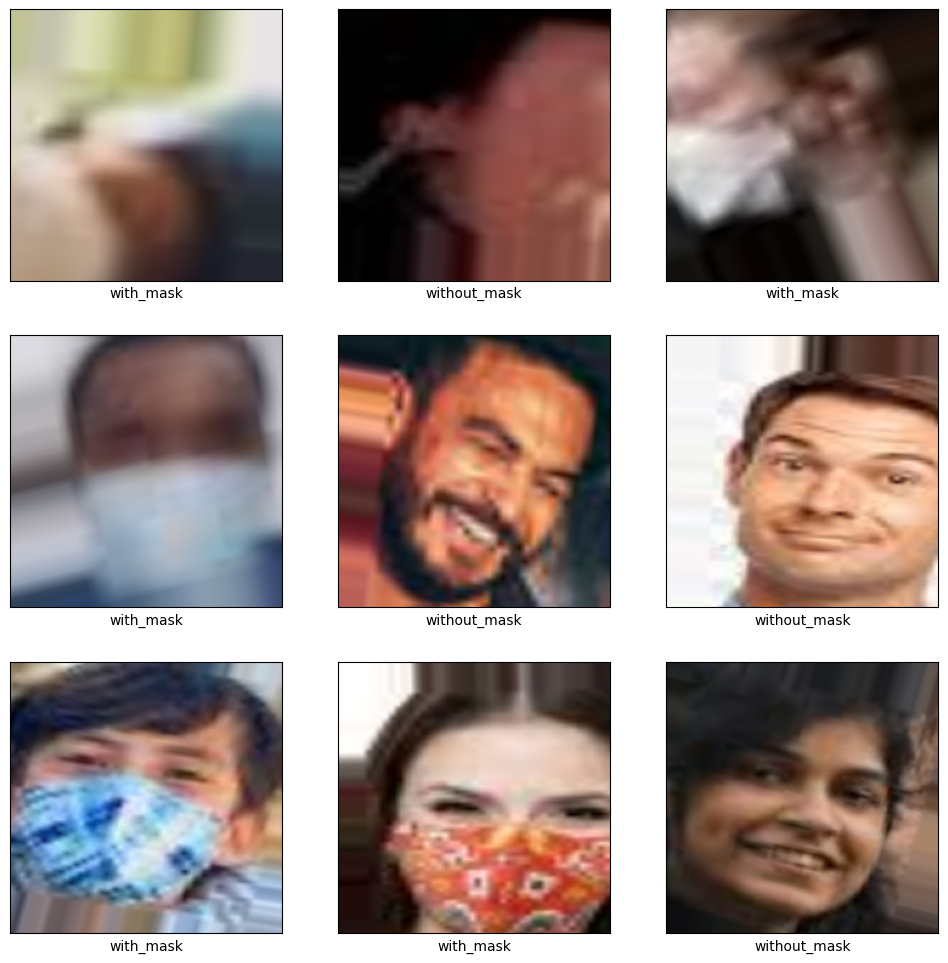

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names manually
class_names = ['with_mask', 'without_mask']

# Function to plot images with labels
def plot_images(images, labels, class_names):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        # Convert labels from numeric to class names
        label = class_names[int(labels[i])]
        plt.xlabel(label)
    plt.show()

# Get a batch of images and labels
images_batch, labels_batch = next(train_generator)

# Plot the images with labels
plot_images(images_batch, labels_batch, class_names)


In [ ]:
# Build the model using transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('face_mask_detection_model.h5')

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
72/72 [==============================] - 37s 404ms/step - loss: 12.6209 - accuracy: 0.8132 - val_loss: 7.9211 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 27s 381ms/step - loss: 5.4502 - accuracy: 0.8677 - val_loss: 3.4370 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 27s 382ms/step - loss: 2.4654 - accuracy: 0.8734 - val_loss: 1.6635 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 27s 382ms/step - loss: 1.3070 - accuracy: 0.8818 - val_loss: 0.9692 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 5/100
72/72 [==============================] - 28s 387ms/step - loss: 0.8831 - accuracy: 0.8760 - val_loss: 0.7082 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 6/100
72/72 [==============================] - 28s 389ms/step - loss: 0.7176 - accuracy: 0.8712 - val_loss: 0.5869 - val_accuracy: 0.8986 - lr: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/My Drive/face_mask_detection_model.h5')

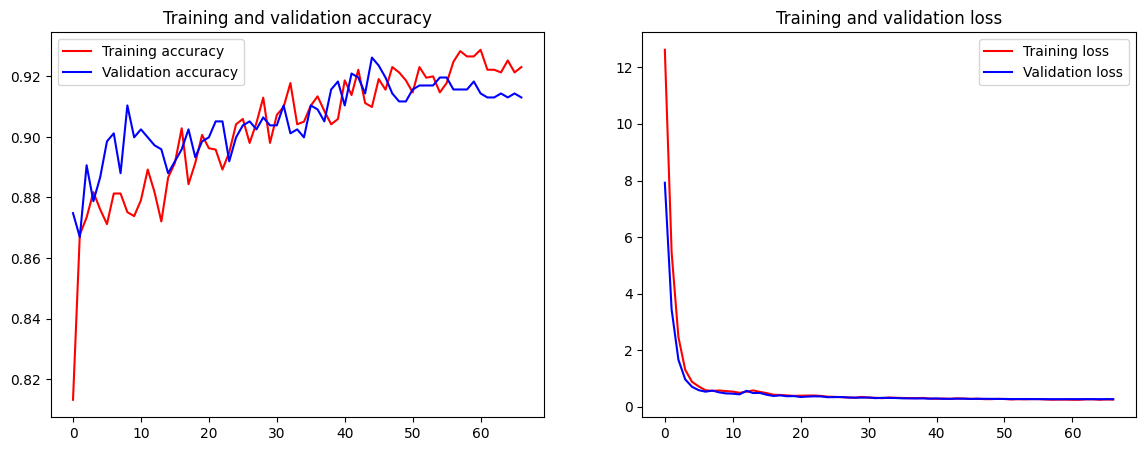

In [ ]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['with_mask', 'without_mask']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

24/24 [==============================] - 2s 43ms/step
Classification Report:
              precision    recall  f1-score   support

   with_mask       0.93      0.94      0.93       503
without_mask       0.88      0.86      0.87       256

    accuracy                           0.91       759
   macro avg       0.90      0.90      0.90       759
weighted avg       0.91      0.91      0.91       759

Confusion Matrix:
[[473  30]
 [ 36 220]]


In [ ]:
import cv2
import numpy as np
from mtcnn import MTCNN
from google.colab.patches import cv2_imshow
import tensorflow as tf

# Function to expand the bounding box
def expand_bbox(bbox, expansion_factor=0.3):
    x, y, w, h = bbox
    new_w = int(w * (1 + expansion_factor))
    new_h = int(h * (1 + expansion_factor))
    new_x = max(0, x - (new_w - w) // 2)
    new_y = max(0, y - (new_h - h) // 2)
    return new_x, new_y, new_w, new_h

# Function to preprocess face image for prediction
def preprocess_face(face_img, target_size=(224, 224)):
    face_img = cv2.resize(face_img, target_size)
    face_img = face_img / 255.0  # Normalize to [0, 1]
    face_img = np.expand_dims(face_img, axis=0)  # Add batch dimension
    return face_img

# Initialize the face detector with adjusted parameters
detector = MTCNN(
    min_face_size=15,  # Adjust as needed
    scale_factor=0.5,  # Adjust as needed
    steps_threshold=[0.4, 0.4, 0.3]  # Lower values for more sensitivity
)

# Load the trained model
model = tf.keras.models.load_model('face_mask_detection_model.h5')
class_names = ['with_mask', 'without_mask']

# Define a confidence threshold for uncertain predictions
confidence_threshold = 0.44

# Path to the video file or 0 for webcam
video_path = '/content/drive/My Drive/screen-capture.webm'

# Open the video file
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces in the frame
    faces = detector.detect_faces(frame)
    for face in faces:
        x, y, w, h = face['box']
        x, y, w, h = expand_bbox((x, y, w, h), expansion_factor=0.3)  # Adjust the expansion factor as needed
        face_img = frame[y:y+h, x:x+w]

        if face_img.size == 0:
            continue

        # Preprocess the face image
        face_img = preprocess_face(face_img)

        # Predict using the trained model
        pred = model.predict(face_img)
        confidence = pred[0][0]
        class_idx = int(confidence > 0.5)

        # Debug: print prediction
        print(f"Prediction: {pred[0][0]}, Class Index: {class_idx}")

        # Check if prediction is uncertain
        if confidence > confidence_threshold and confidence < (1 - confidence_threshold):
            label = f"Uncertain: {confidence:.2f}"
            color = (0, 255, 255)  # Yellow color for uncertain predictions
        else:
            # Get the class name
            class_name = class_names[class_idx]
            color = (0, 255, 0) if class_idx == 0 else (0, 0, 255)
            label = f"{class_name}: {confidence:.2f}"

        # Draw bounding box and label on the frame
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the frame
    cv2_imshow(frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video file and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.